In [1]:
!gdown --id 1oXLMVnuYZ0tX-MzMG8N8lwMsC5-aM-nv --output anotacoes_especialistas.csv
!gdown --id 1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_ --output CSV.zip
!unzip CSV.zip

Downloading...
From: https://drive.google.com/uc?id=1oXLMVnuYZ0tX-MzMG8N8lwMsC5-aM-nv
To: /content/anotacoes_especialistas.csv
2.61MB [00:00, 81.0MB/s]
Downloading...
From: https://drive.google.com/uc?id=1wG0iOHehIWF38kEpGhuHfFRotBBMC9t_
To: /content/CSV.zip
100% 1.32M/1.32M [00:00<00:00, 82.8MB/s]
Archive:  CSV.zip
   creating: CSV/
  inflating: CSV/original.csv        
  inflating: CSV/val.csv             
  inflating: CSV/test.csv            
  inflating: CSV/train.csv           
  inflating: CSV/train_additional_data.csv  


In [2]:
import pandas as pd
import numpy as np
from collections import Counter
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import GridSearchCV

In [3]:
!pip install dtreeviz

     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for dtreeviz: filename=dtreeviz-1.3-cp37-none-any.whl size=66640 sha256=1204c398eb5f5abfa41090be87fecb98bbc4f521eb7b2679759c9a400207ab8d
  Stored in directory: /root/.cache/pip/wheels/60/36/b1/188ee35c677e48463f6482d580f81c19f5f82ae5adbe293fd8
Successfully built dtreeviz


In [4]:
from dtreeviz.trees import dtreeviz

In [5]:
import pandas as pd

train_index = pd.read_csv('/content/CSV/train.csv')
val_index = pd.read_csv('/content/CSV/val.csv')
dados = pd.read_csv('/content/anotacoes_especialistas.csv')
train = dados.iloc[list(train_index['original_index'].values), 10:]
val = dados.iloc[list(val_index['original_index'].values), 10:]
train = train[sorted(train.columns.tolist())]
val = val[sorted(val.columns.tolist())]

In [6]:
X_train = []
for amostra in train.values:
  row = []
  for i in range(0, len(amostra), 3):
    arr = np.array([amostra[i], amostra[i+1], amostra[i+2]])
    row.append(int(np.nanmean(arr)))
  X_train.append(row)
X_train = np.array(X_train)

X_val = []
for amostra in val.values:
  row = []
  for i in range(0, len(amostra), 3):
    arr = np.array([amostra[i], amostra[i+1], amostra[i+2]])
    row.append(int(np.nanmean(arr)))
  X_val.append(row)
X_val = np.array(X_val)

In [7]:
X_train.shape, X_val.shape

((1111, 10), (278, 10))

In [8]:
y_train = dados.iloc[list(train_index['original_index'].values), 9].values
y_val = dados.iloc[list(val_index['original_index'].values), 9].values

In [9]:
counter = Counter(y_train)  
max_val = float(max(counter.values()))  
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}    
class_weights 

{0.0: 1.3982300884955752, 1.0: 1.0, 2.0: 1.5906040268456376}

In [10]:
params = {'max_depth': [3, 5, 10, 15, 20], 'n_estimators': [1, 5, 10, 20, 50, 100, 200, 500]}
rf = RandomForestClassifier(class_weight=class_weights)
clf = GridSearchCV(rf, param_grid=params, scoring='balanced_accuracy', cv=5)
clf.fit(X_train, y_train)
rf = clf.best_estimator_
print(rf)

pred = rf.predict(X_val)

print(confusion_matrix(y_val, pred))

cm = confusion_matrix(y_val, pred)
cm = cm / cm.astype(np.float).sum(axis=1, keepdims=True)
balanced_acc = np.trace(cm) / 3
print('Acuracia balanceada na validacao:', balanced_acc)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                       class_weight={0.0: 1.3982300884955752, 1.0: 1.0,
                                     2.0: 1.5906040268456376},
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
[[22 31 35]
 [29 54 24]
 [20 37 26]]
Acuracia balanceada na validacao: 0.3559753030814848


In [12]:
rf[0]

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=684450990, splitter='best')

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


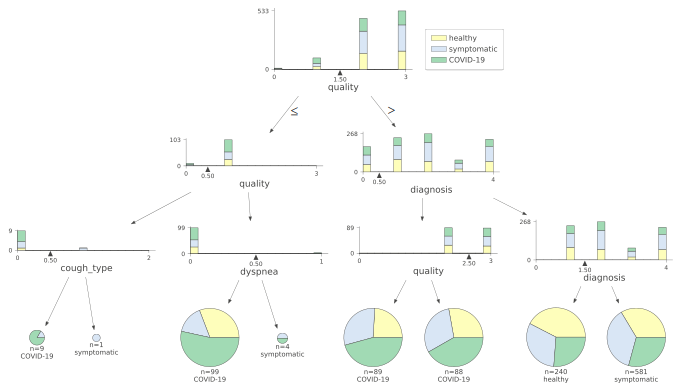

In [13]:
viz = dtreeviz(rf[0], X_train, y_train,
               feature_names=['choking', 'congestion', 'cough_type', 'diagnosis', 'dyspnea', 'nothing', 'quality', 'severity', 'stridor', 'wheezing'],
              class_names=['healthy','symptomatic','COVID-19'])

viz

In [ ]:
viz.save("decision_tree.svg")

In [14]:
import pickle

pickle.dump(rf, open('rf.sav', 'wb'))